Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Vector Quantized Variational Autoencoders and Transformers with MedNIST Dataset

This tutorial illustrates how to use MONAI for training a Vector Quantized Variational Autoencoder (VQVAE)[1,2] and a transformer model on 2D images.

This is a two step process:
- We will train our VQVAE model to be able to reconstruct the input images.
- This will be followed by using the trained VQVAE model to encode images to feed into the transformer network to train.

We will work with the [MedNIST dataset](https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset) available on MONAI. In order to train faster, we will select just one of the available classes ("HeadCT"), resulting in a training set with 7999 2D images.

[1] - Oord et al. "Neural Discrete Representation Learning" https://arxiv.org/abs/1711.00937

[2] - Tudosiu et al. "Morphology-Preserving Autoregressive 3D Generative Modelling of the Brain" https://arxiv.org/abs/2209.03177

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
import os
import tempfile
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch.nn import L1Loss, CrossEntropyLoss

from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism, ensure_tuple
from monai.inferers import VQVAETransformerInferer
from monai.networks.nets import VQVAE, DecoderOnlyTransformer
from monai.utils.ordering import Ordering
from monai.utils.enums import OrderingType

print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.4.0rc6
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a0e1b043ba2890e1463fa49df76f66e56a68b08
MONAI __file__: /home/<username>/miniconda3/envs/monai/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.0
pynrrd version: 1.0.0
clearml version: 1.16.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp05g42ckq


## Set deterministic training for reproducibility

In [ ]:
set_determinism(42)

## Download training data

In [4]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
image_size = 64
batch_size = 16
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:01, 43.5MB/s]                              

2024-09-05 22:08:09,502 - INFO - Downloaded: /tmp/tmp05g42ckq/MedNIST.tar.gz


2024-09-05 22:08:09,611 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-05 22:08:09,612 - INFO - Writing into directory: /tmp/tmp05g42ckq.


Loading dataset: 100%|██████████| 47164/47164 [00:20<00:00, 2354.04it/s]


## Visualse some examples from the dataset

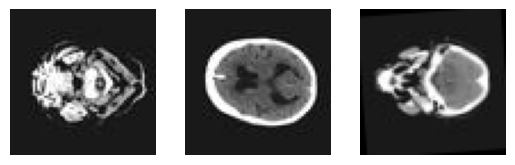

In [5]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Download Validation Data

In [6]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

2024-09-05 22:08:35,477 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-05 22:08:35,478 - INFO - File exists: /tmp/tmp05g42ckq/MedNIST.tar.gz, skipped downloading.
2024-09-05 22:08:35,480 - INFO - Non-empty folder exists in /tmp/tmp05g42ckq/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:02<00:00, 2562.28it/s]


## VQVAE Training
The first step is to train a VQVAE network - once this is done we can use the trained vqvae model to encode the 2d images to generate the inputs required for the transformer

### Define network, optimizer and losses

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
vqvae_model = VQVAE(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    channels=(256, 256),
    num_res_channels=(256, 256),
    num_embeddings=256,
    embedding_dim=32,
)
vqvae_model = vqvae_model.to(device)

Using cuda:1


In [8]:
optimizer = torch.optim.Adam(params=vqvae_model.parameters(), lr=1e-4)
l1_loss = L1Loss()

### VQVAE Model training
We will run our model for 100 epochs

In [9]:
max_epochs = 100
val_interval = 10
epoch_recon_loss_list = []
epoch_quant_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(max_epochs):
    vqvae_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # model outputs reconstruction and the quantization error
        reconstruction, quantization_loss = vqvae_model(images=images)

        recons_loss = l1_loss(reconstruction.float(), images.float())

        loss = recons_loss + quantization_loss

        loss.backward()
        optimizer.step()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix(
            {"recons_loss": epoch_loss / (step + 1), "quantization_loss": quantization_loss.item() / (step + 1)}
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_quant_loss_list.append(quantization_loss.item() / (step + 1))

    if (epoch + 1) % val_interval == 0:
        vqvae_model.eval()
        val_loss = 0
        with torch.no_grad():
            k = 0
            for val_step, batch in enumerate(val_loader, start=1):
                k += 1
                if k == 3:
                    break
                images = batch["image"].to(device)

                reconstruction, quantization_loss = vqvae_model(images=images)

                # get the first sample from the first validation batch for
                # visualizing how the training evolves
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 3: 100%|█████████████████| 63/63 [00:11<00:00,  5.40it/s, recons_loss=0.0335, quantization_loss=2.14e-5]
...
Epoch 99: 100%|████████████████| 63/63 [00:11<00:00,  5.39it/s, recons_loss=0.0159, quantization_loss=6.46e-5]


train completed, total time: 1178.9762766361237.


### VQVE Loss Curve

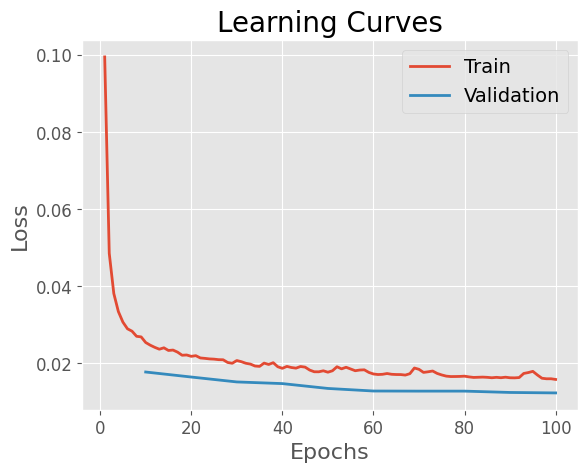

In [10]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

###  Plotting  evolution of reconstruction performance

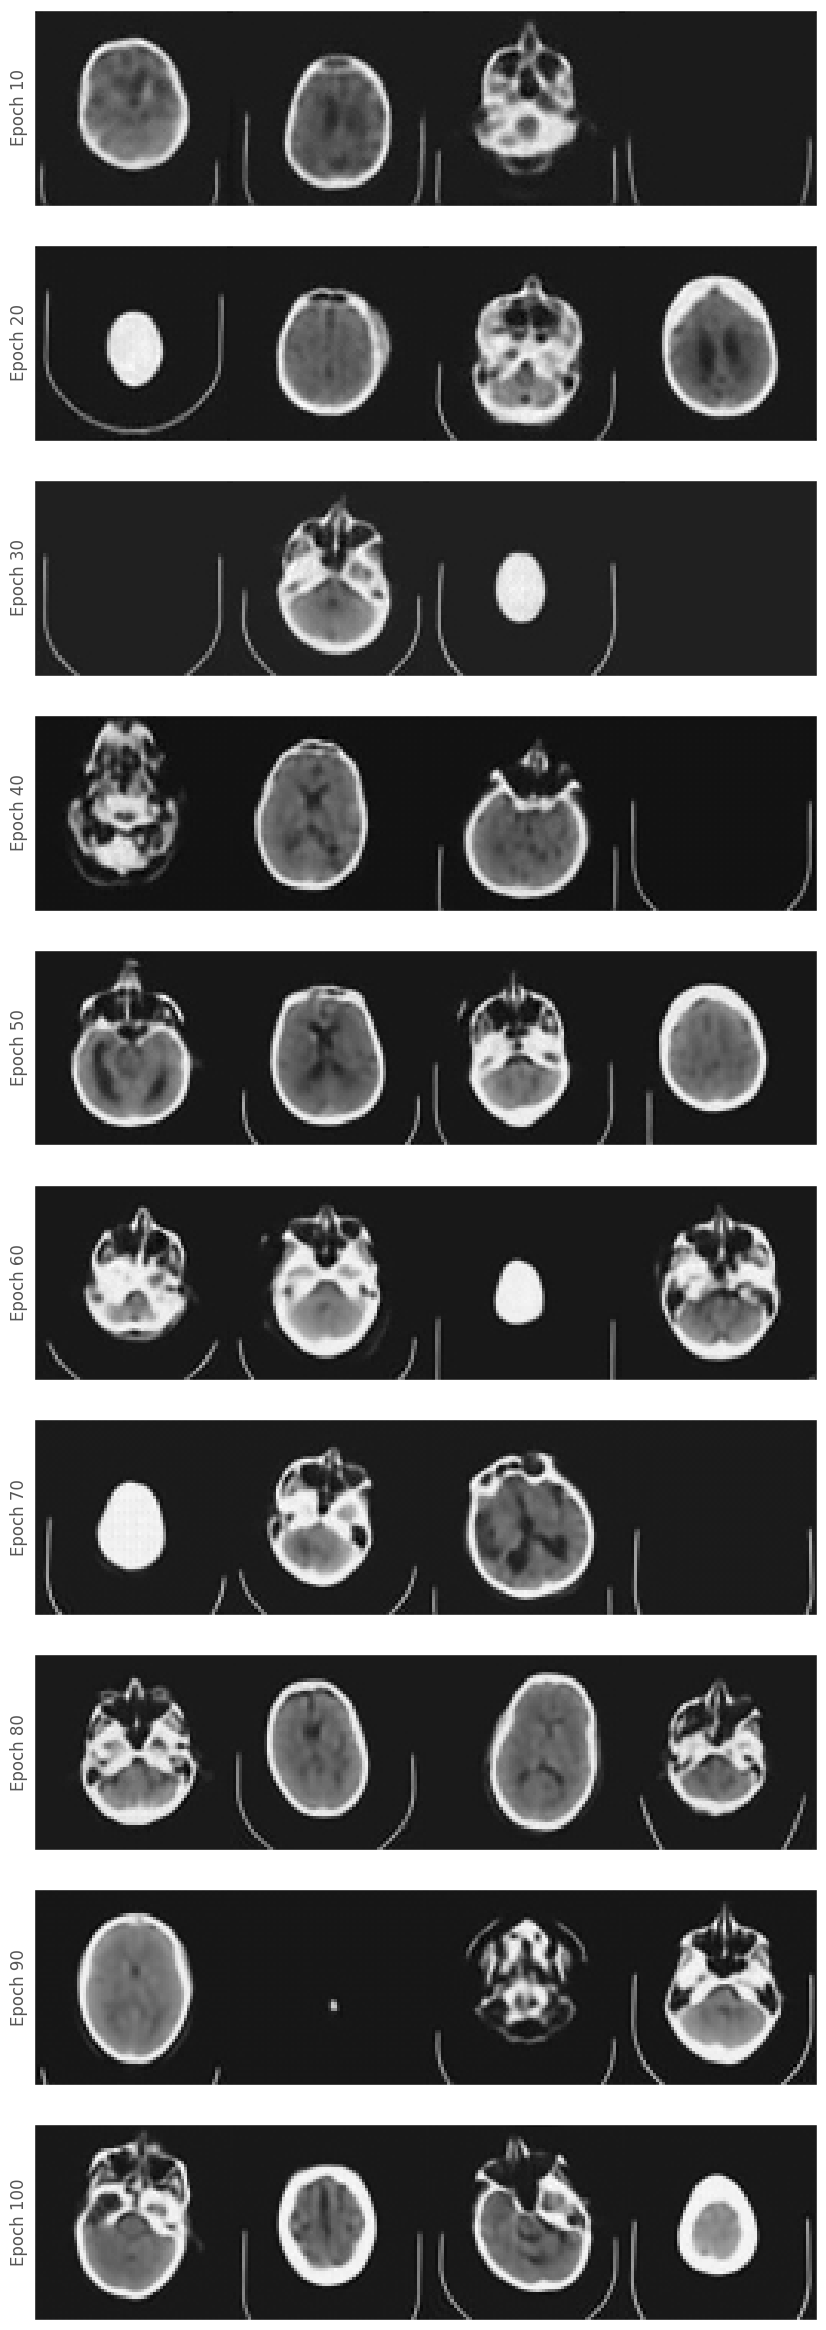

In [11]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, max_epochs, int(max_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
fig.set_size_inches(18, 30)
ax = ensure_tuple(ax)

for image_n in range(len(val_samples)):
    reconstructions = torch.reshape(intermediary_images[image_n], (64 * n_example_images, 64)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

### Plot reconstructions of final trained vqvae model

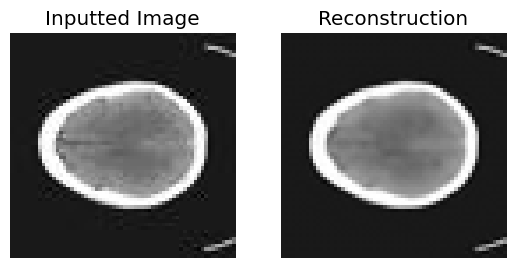

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

## Transformer Training
Now that a vqvae model has been trained, we can use this model to encode the data into its discrete latent representations. These inputs can then be flattened into a 1D sequence for the transformer to learn in an autoregressive manor.

Training can be done in 2 ways:
- Loading in the original images and then encoding these images on the fly during training using the vqvae model, the advantage of this is we can augment training data during training that is then encoded, however this will slow down training and is more memory intensive.
- Before training the transformer we encode all the training data first and save the discrete encodings. These latent codes are then loaded and fed to the transformer for training.

For this tutorial we will use the first appraoch and use the vqvae network to encode the data during the training cycle

### Datasets
We can use the same dataloader with augmentations as used for training the VQVAE model. However given the memory intensive nature of Transformer models we will need to reduce the batch size

In [13]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)

### Latent sequence ordering
We need to define an ordering of which we convert our 2D latent space into a 1D sequence. For this we will use a simple raster scan.

In [14]:
# Get spatial dimensions of encoded data
test_scan = next(iter(train_loader))["image"].to(device)
spatial_shape = vqvae_model.encode_stage_2_inputs(test_scan).shape[2:]

ordering = Ordering(ordering_type=OrderingType.RASTER_SCAN.value, spatial_dims=2, dimensions=(1,) + spatial_shape)

### Begin of sentence token (BOS)

After we transform the data into a 1D representation, we need to define a value token to define the begining of the sequence (a.k.a., BOS token in NLP). This way, when we feed it to the transformer, the transformer will predict what is the value of the first valid token in the sequence. Since in the VQ-VAE, we are using the token values from 0 to 255 to define the elements of the codebook, here we will specify the next value as the be BOS, i.e. 256.

In [15]:
bos_token = 256

## Define Network, optimizer and losses

In [19]:
transformer_model = DecoderOnlyTransformer(
    num_tokens=256 + 1,  # 256 from num_embeddings input of VQVAE + 1 for Begin of Sentence (BOS) token
    max_seq_len=spatial_shape[0] * spatial_shape[1],
    attn_layers_dim=96,
    attn_layers_depth=12,
    attn_layers_heads=8,
)
transformer_model = transformer_model.to(device)

inferer = VQVAETransformerInferer()

In [20]:
optimizer = torch.optim.Adam(params=transformer_model.parameters(), lr=5e-4)
ce_loss = CrossEntropyLoss()

### Transformer Model Training
We will train the model for 50 epochs

In [21]:
max_epochs = 50
val_interval = 10
epoch_ce_loss_list = []
val_ce_epoch_loss_list = []
intermediary_images = []
vqvae_model.eval()

total_start = time.time()
for epoch in range(max_epochs):
    transformer_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)

        optimizer.zero_grad(set_to_none=True)

        logits, target, _ = inferer(images, vqvae_model, transformer_model, ordering, return_latent=True)
        logits = logits.transpose(1, 2)

        loss = ce_loss(logits, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"ce_loss": epoch_loss / (step + 1)})
    epoch_ce_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        transformer_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                logits, quantizations_target, _ = inferer(
                    images, vqvae_model, transformer_model, ordering, return_latent=True
                )
                logits = logits.transpose(1, 2)

                loss = ce_loss(logits, quantizations_target)

                # Generate a random sample to visualise progress
                if val_step == 1:
                    sample = inferer.sample(
                        vqvae_model=vqvae_model,
                        transformer_model=transformer_model,
                        ordering=ordering,
                        latent_spatial_dim=(spatial_shape[0], spatial_shape[1]),
                        starting_tokens=vqvae_model.num_embeddings * torch.ones((1, 1), device=device),
                    )
                    intermediary_images.append(sample[:, 0])

                val_loss += loss.item()

        val_loss /= val_step
        val_ce_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:   0%|                                                                        | 0/500 [00:00<?, ?it/s]

Epoch 2: 100%|████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.56it/s, ce_loss=2.73]
...
100%|██████████| 256/256 [00:02<00:00, 108.28it/s]


train completed, total time: 1618.526816368103.


### Transformer Loss Curve

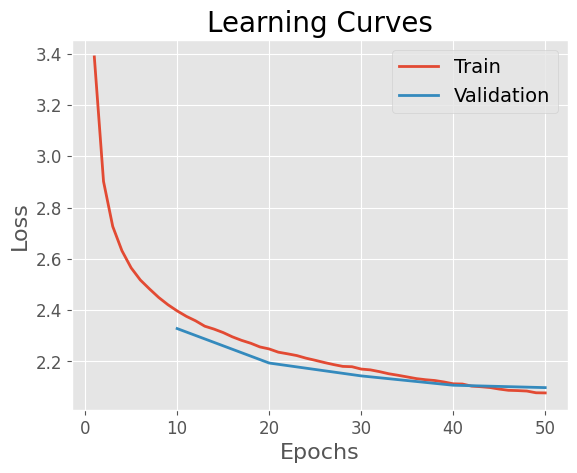

In [22]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_ce_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_ce_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Plot evoluation of Generated Samples

5


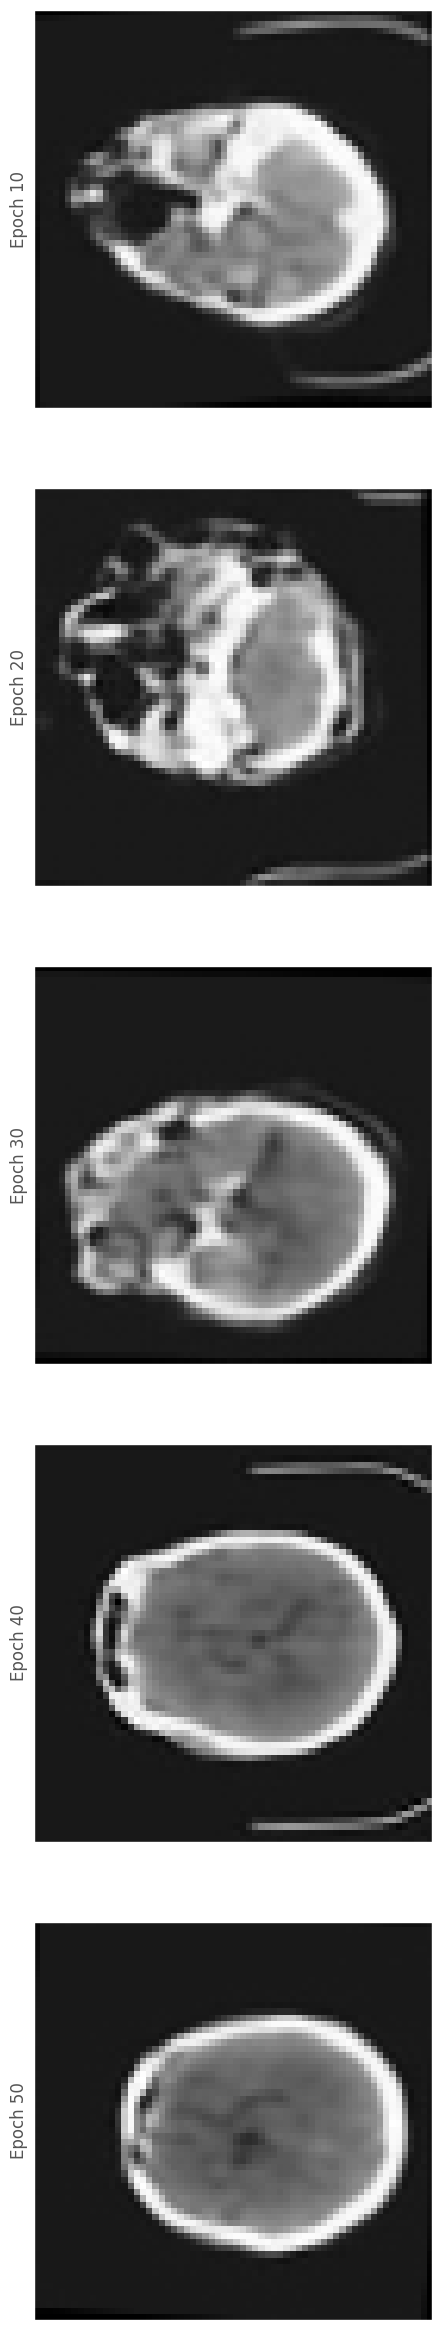

In [23]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, max_epochs, int(max_epochs / val_interval))
print(len(val_samples))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
fig.set_size_inches(12, 30)
ax = ensure_tuple(ax)

for image_n in range(len(val_samples)):
    reconstructions = intermediary_images[image_n][0]
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

### Generating samples from the trained model

In [24]:
samples = []
for _ in range(5):
    sample = inferer.sample(
        vqvae_model=vqvae_model,
        transformer_model=transformer_model,
        ordering=ordering,
        latent_spatial_dim=(spatial_shape[0], spatial_shape[1]),
        starting_tokens=vqvae_model.num_embeddings * torch.ones((1, 1), device=device),
    )
    samples.append(sample[:, 0])

100%|██████████| 256/256 [00:01<00:00, 128.55it/s]


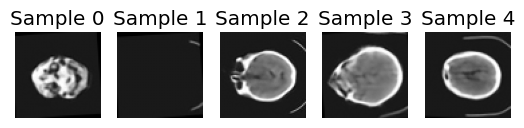

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=5)
for i in range(5):
    ax[i].imshow(samples[i][0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    ax[i].axis("off")
    ax[i].title.set_text("Sample " + str(i))
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [26]:
if directory is None:
    shutil.rmtree(root_dir)